# Deep learning for timeseries. F.Chollet

A temperature forecasting example.  

Predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity

In [13]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams["figure.figsize"] =(18,9) 
plt.style.use('ggplot')
import os, pathlib, shutil, random, urllib, zipfile

In [ ]:
url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
extract_dir = "."

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [19]:
jena = pd.read_csv('jena_climate_2009_2016.csv')
jena.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


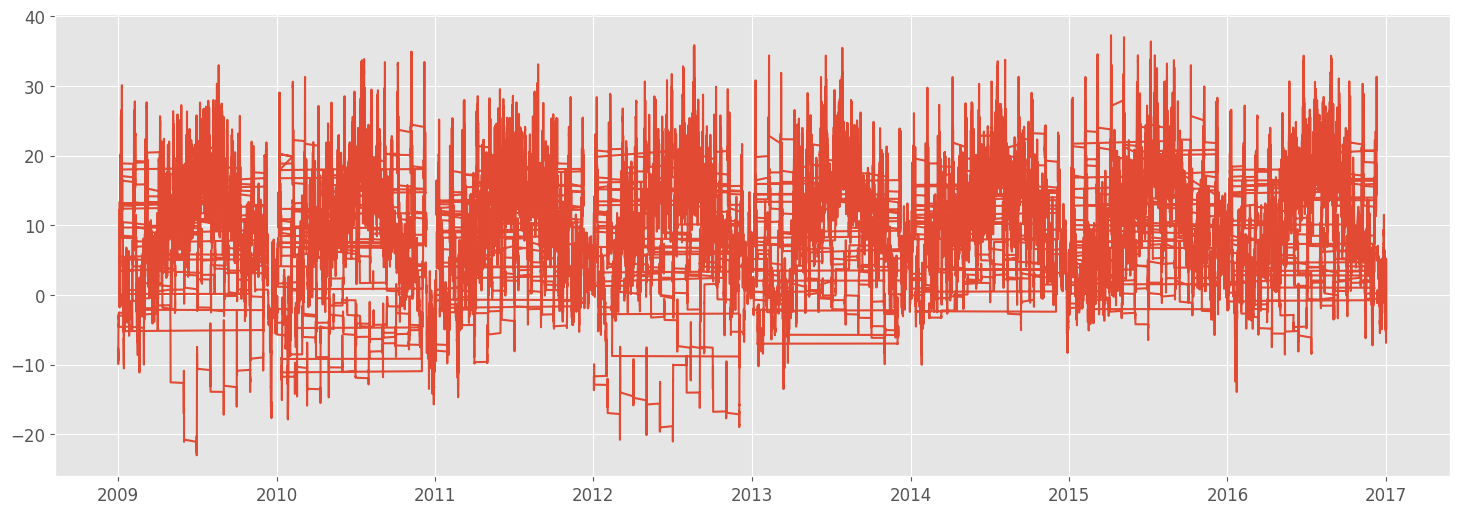

In [3]:
jena['Date Time'] = pd.to_datetime(jena['Date Time'])
plt.plot(jena['Date Time'], jena['T (degC)'])
plt.grid(True)


In [4]:
jena.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date Time        420451 non-null  datetime64[ns]
 1   p (mbar)         420451 non-null  float64       
 2   T (degC)         420451 non-null  float64       
 3   Tpot (K)         420451 non-null  float64       
 4   Tdew (degC)      420451 non-null  float64       
 5   rh (%)           420451 non-null  float64       
 6   VPmax (mbar)     420451 non-null  float64       
 7   VPact (mbar)     420451 non-null  float64       
 8   VPdef (mbar)     420451 non-null  float64       
 9   sh (g/kg)        420451 non-null  float64       
 10  H2OC (mmol/mol)  420451 non-null  float64       
 11  rho (g/m**3)     420451 non-null  float64       
 12  wv (m/s)         420451 non-null  float64       
 13  max. wv (m/s)    420451 non-null  float64       
 14  wd (deg)         420

In [5]:
jena.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [7]:
features = jena.loc[:,['p (mbar)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']]
target = jena.loc[:,'T (degC)']

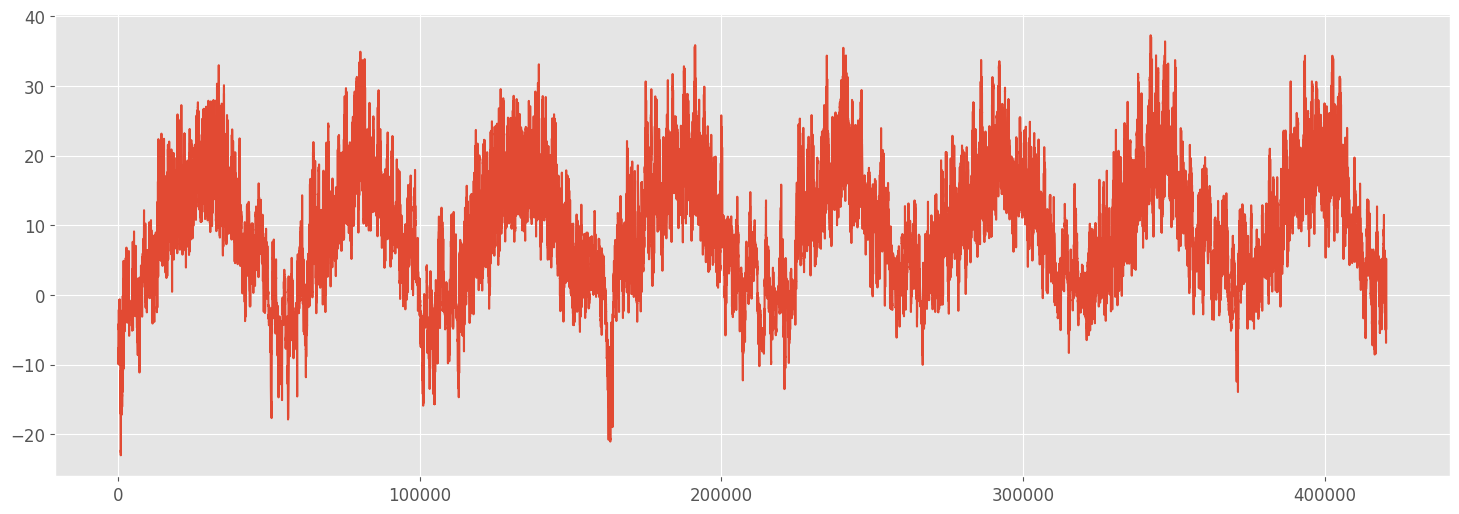

In [8]:

plt.plot(range(len(target)), target.values)
plt.grid(True)

# The stationality can be seen in this plot, also some extreme values

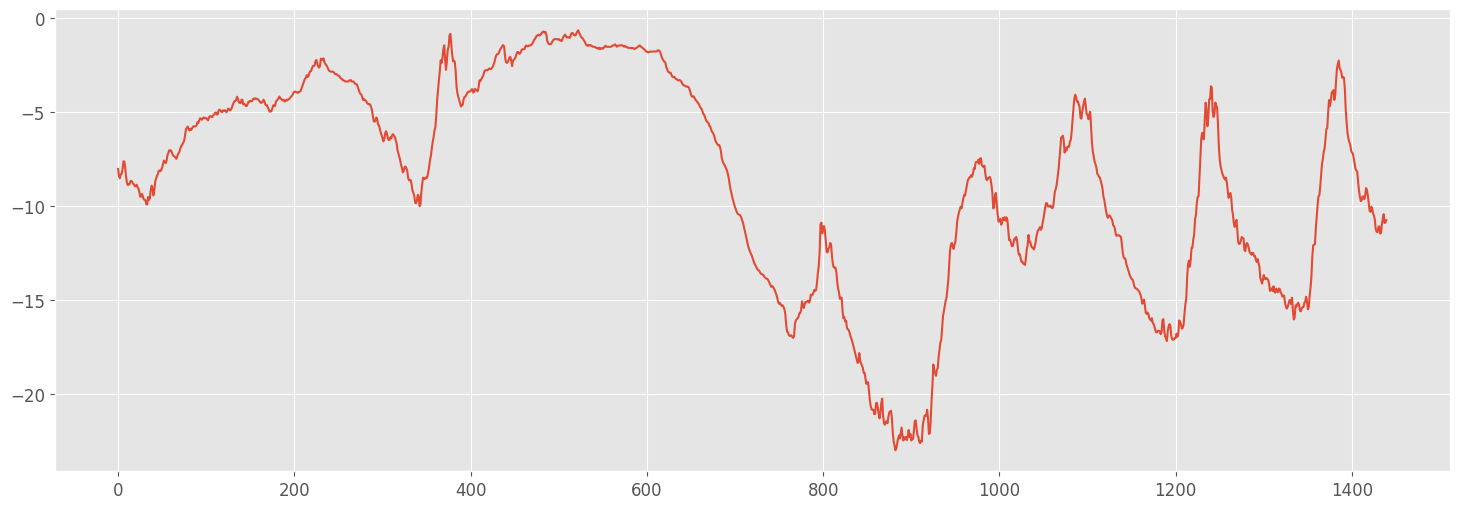

In [9]:
plt.plot(range(1440), target.values[:1440])
plt.grid(True)

## Seasonal and Trend Decomposition

In [48]:
6*24*365 # Lectures per year

52560

In [49]:
24*365

8760

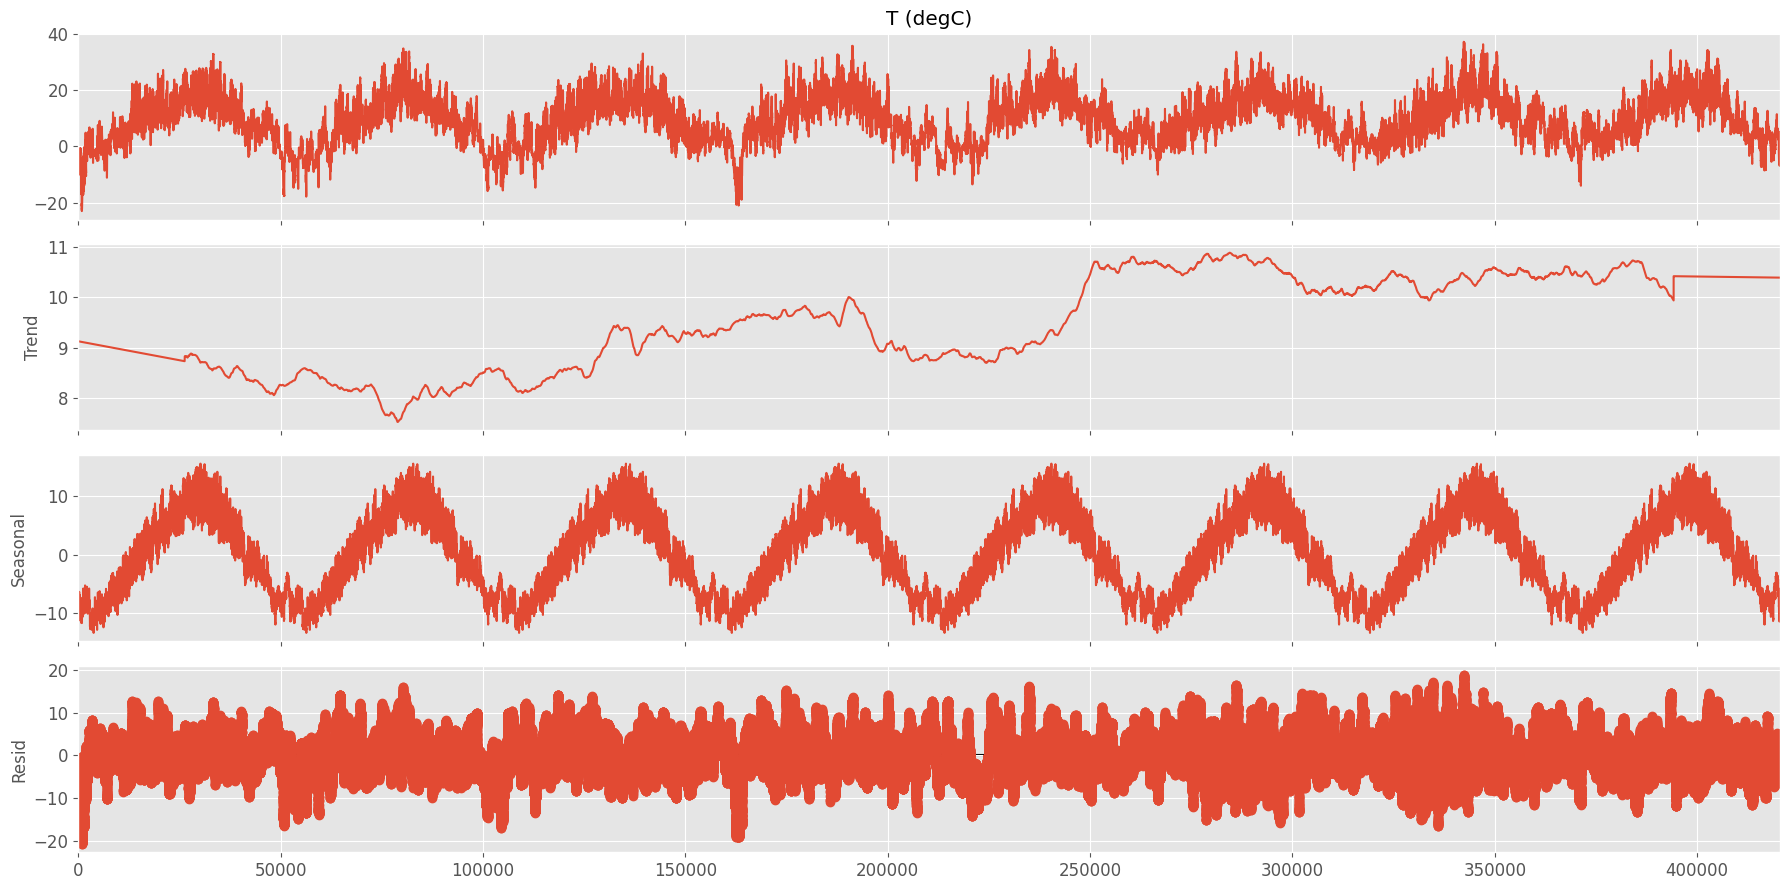

In [22]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(target, period = 52560, model= 'additive', extrapolate_trend='freq')
fig = res.plot()

In [43]:
target_res = pd.Series(target.values, index=pd.date_range("1-1-2009", periods = len(target),freq='10min'))
target_res = target_res.resample('D').mean().ffill()

stl = STL(target_res, seasonal = 365)
res = stl.fit()
fig = res.plot()

2009-01-01 00:00:00   -8.02
2009-01-01 00:10:00   -8.41
2009-01-01 00:20:00   -8.51
2009-01-01 00:30:00   -8.31
2009-01-01 00:40:00   -8.27
                       ... 
2016-12-29 18:20:00   -4.05
2016-12-29 18:30:00   -3.35
2016-12-29 18:40:00   -3.16
2016-12-29 18:50:00   -4.23
2016-12-29 19:00:00   -4.82
Freq: 10T, Length: 420451, dtype: float64